# Tutorial 9: Bayes Classifier

In [2]:
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sys
import os
from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from CIBer import CIBer

In [3]:
FDA_DIR = os.path.join(os.getcwd(), os.pardir, r'PycharmProjects/Financial-Data-Analytics')
DATA_DIR = rf'{FDA_DIR}/Datasets'

def read_file(filename, dir=None, static=False, **kwargs):
    if dir is None:
        dir = DATA_DIR
        
    path = os.path.join(dir, filename)
    extension = filename.rsplit('.', 1)[-1]

    if extension == 'csv':
        return pd.read_csv(path, **kwargs)
    elif extension in ['parq', 'parquet']:
        return pd.read_parquet(path, **kwargs)
    elif extension == 'json':
        with open(path, 'r') as file:
            return json.load(file)
    elif extension == 'xlsx':
        return pd.read_excel(path, **kwargs)
    else:
        raise NotImplementedError

In [4]:
def confusion_matrix_metrics(y_test, y_pred):
    y_test = pd.Series(np.array(y_test), name='truth')
    y_pred = pd.Series(np.array(y_pred), name='pred')

    all_classes = np.sort(pd.concat([y_test, y_pred]).unique())
    
    conf_mat = y_pred.groupby([y_pred, y_test]).count().unstack()
    conf_mat = conf_mat.reindex(all_classes).reindex(all_classes, axis=1).fillna(0).astype(int)
    
    test_stat = precision_recall_fscore_support(y_test, y_pred, labels=all_classes, zero_division=np.nan)
    test_stat = pd.DataFrame({stat: score for stat, score in 
                              zip(['precision', 'recall', 'fscore', 'support'], test_stat)},
                              index=all_classes)
    return conf_mat, test_stat

## 1. Naive Bayes Classifier

Suppose that we are given a training set with $n$ samples
\begin{equation*}
	\mathcal{D} = \{(\mathbf x^1, c(\mathbf x^1)), (\mathbf x^2, c(\mathbf x^2)), \dots, (\mathbf x^n, c(\mathbf x^n)) \} \, ,
\end{equation*}
where each object is represented by its binary (dummy) feature vector $\mathbf x^i = (x_1^i,\dots,x^i_d) \in \{0, 1\}^d$ and $c(\mathbf x^i)$ is the corresponding classification. 

Let $\mathcal{C} = \{c_1,\dots, c_\ell\}$ be the set of all possible classification labels that $c(\mathbf x)$ may take values in. The empirical probability is then:
\begin{equation}
	\mathbb{P}({\rm c}(\mathbf x^*) = c_j | {\bf x}=\mathbf x^*) = \frac{\mathbb{P}({\bf x}=\mathbf x^* | {\rm c}(\mathbf x^*) = c_j) \mathbb{P}({\rm c}(\mathbf x^*) = c_j)}{\mathbb{P}({\bf x}=\mathbf x^*)} \, ,
\end{equation}
where the law of total probabilities tells us that:
\begin{equation*}
	\mathbb{P}({\bf x}=\mathbf x^*) = \sum_{j=1}^\ell \mathbb{P}({\bf x}=\mathbf x^* | {\rm c}(\mathbf x^*) = c_j) \mathbb{P}({\rm c}(\mathbf x^*) = c_j) \, .
\end{equation*}
We can easily compute the empirical probability of the label as:
\begin{equation*}
	\hat{\mathbb{P}} ({\rm c}(\mathbf x)=c_j) = \frac{|i: c(\mathbf x^i) = c_j|}{|\mathcal{D}|} \, .
\end{equation*}

\
However, these empirical probabilities would be accurate estimates for the true conditional probabilities,

only when the sample size is large enough that can cover most of the combinations of $\mathbf x$ and $c(\mathbf x)$ in $\mathcal{X}$ and $\mathcal{C}$ respectively. 

We therefore consider a naive model, that is, we assume all the $p$ features are conditionally independent.

### 1.1 Conditional Independence

Then, the conditional probability becomes
\begin{equation}
\begin{aligned} 
	\mathbb{P}({\rm c}(\mathbf x^*) = c_j | {\bf x}=\mathbf x^*) &= \frac{\prod\limits_{k=1}^d \mathbb{P}({\rm x}_k=x_k^*|{\rm c}(\mathbf x^*)=c_j) \mathbb{P}({\rm c}(\mathbf x^*)=c_j)}{\mathbb{P}({\bf x}=\mathbf x^*)} \\
			&\propto \prod_{k=1}^d \mathbb{P}({\rm x}_k=x_k^*|{\rm c}(\mathbf x^*)=c_j) \mathbb{P}({\rm c}(\mathbf x^*)=c_j) \, .
\end{aligned}
\end{equation}

Hence, with a constant number of possible values for each feature, less training samples are required.

<u>Note</u>: if each combination has one observation, there are $2 \times d \times |\mathcal{C}|$ entries.

\
Under this naive assumption, the empirical probabilities can be estimated by
\begin{equation}
	p_{kj} := \hat{\mathbb{P}}_{\rm Dummy} ({\rm x}_k=x_k|{\rm c}(\mathbf x)=c_j) = \frac{|i: x_k^i=x_k, c(\mathbf x^i)=c_j|}{|i: c(\mathbf x^i) = c_j|} \, , \qquad x_k \in \{0, 1\} \, ,
\end{equation}

### 1.2 Categorical Naive Bayes

Dummy Naive Bayes classifier only deals with binary feature matrix, while its categorical version can deal with any possible integers 

(If each combination has one observation, there are $|\mathcal{X}_1| \times |\mathcal{X}_2| \times \cdots \times |\mathcal{X}_p| \times |\mathcal{C}|$ entries). 

The settings in Categorical Naive Bayes classifier and in Dummy Na\"ive Bayes classifier are the same:

\begin{equation}
	q_{kj} := \hat{\mathbb{P}}_{\mathbf Cate} ({\mathbf x}_k=x_k|{\mathbf c}(\mathbf x)=c_j) = \frac{|i: x_k^i=x_k, c(\mathbf x^i)=c_j|}{|i: c(\mathbf x^i) = c_j|} \, , \qquad x_k \in \mathcal{X}_k \, ,
\end{equation}

## 2. Distributional Naive Bayes Classifier

We can impose different distribution assumptions to the feature matrix such that we have:
1. Bernoulli Naive Bayes Classifier
2. Multinomial Naive Bayes Classifier
3. Gaussian Naive Bayes Classifier

### 2.1 Bernoulli Naive Bayes Classifier

If each feature variable are binary, we can assume that each conditional feature variables follow a Bernoulli distribution.

Using the definition as in $\hat{\mathbb{P}}_{\rm Dummy}$, we have
\begin{equation*}
	\hat{\mathbb{P}}_{\rm Bern} ({\mathbf x}_k=x_k|{\rm c}(\mathbf x)=c_j) = p_{kj}^{x_k} (1 - p_{kj})^{1 - x_k} \, , \qquad x_k \in \{0, 1\} \, .
\end{equation*}

### 2.2 Multinomial Naive Bayes Classifier

In the circumstance of multinomial event model, the feature vector $x$ of length $d$ denotes the frequencies of $m$ random variables,

where the events have been generated by a multinomial distribution $(p_1, \cdots ,p_d)$. 

\
With the defintion as in $\hat{\mathbb{P}}_{\mathbf Cate}$, the <b>likelihood</b> of an observation $\mathbf x$ given a certain class $c_{j}$ is defined as:
\begin{equation*}
	\hat{\mathbb{P}}_{\rm Multi} ({\bf x}=\mathbf x | {\rm c}(\mathbf x) = c_j) = \frac{(\sum_{k=1}^d x_k)!}{\prod_{k=1}^d x_k!} \cdot \prod_{k=1}^d q_{kj}^{x_k} \, , \qquad x_k \in \mathcal{X}_k \, .
\end{equation*}

### 2.3 Gaussian Naive Bayes Classifier

In the previous two event models, the variables follow discrete distributions. 

However, if the variables are real-valued, a Gaussian distribution can be assumed for each conditional variable. 

Suppose that $x_k$ is a real-valued feature, we first partition the data by the class, 

and then compute its sample mean $\mu_{kj}$ and sample standard deviation $\sigma_{kj}$ within each class $c_{j}$. 

The empirical conditional density of $x_k$ given $c_j$ is estimated by: 
\begin{equation}
	\hat{\mathbb{P}}_{\rm Gauss} ({\rm x}_k=x_k|{\rm c}(\mathbf x)=c_j) = \frac{1}{\sqrt{2\pi \sigma^{2}_{kj}}} \exp\left(-\frac{(x_k-\mu_{kj})^{2}}{2\sigma^{2}_{kj}}\right) \, , \qquad -\infty < x_k < \infty \, .
\end{equation}

\
Of course, we can apply discretization technique to the continuous feature variables,

such that the Categorical Naive Bayes classifier can be adopted to the resulting dataset instead. 

Nonetheless, there must be information loss.

### 2.4 Composite Naive Bayes Classifier

In general, the dataset contains different types of feature variables, including continuous, categorical, and discrete. 

Since we naively assumed the conditional independence, we can combine several distributional Naive Bayes model as a composite model. 

For example, if feature variables ${\rm x}_1$ and ${\rm x}_2$ are categorical, 

${\rm x}_3, {\rm x}_4, {\rm x}_5, {\rm x}_6$ follow a multinomial distribution, 

and ${\rm x}_7, {\rm x}_8$ are real-valued such that we assume they follow Gaussian distribution,

the empirical likelihood of $\mathbf x = (x_1, \cdots, x_8)$ given class $c_j$ becomes:
    
\begin{align*}
	\hat{\mathbb{P}}_{comp}({\bf x}=\mathbf x | {\rm c}(\mathbf x) = c_j) &= \hat{\mathbb{P}}_{\rm Cate} ({\rm x}_1=x_1|{\rm c}(\mathbf x)=c_j) \cdot \hat{\mathbb{P}}_{\rm Cate} ({\rm x}_2=x_2|{\rm c}(\mathbf x)=c_j) \\
			&\quad \times \hat{\mathbb{P}}_{\rm Multi} (({\rm x}_3, {\rm x}_4, {\rm x}_5, {\rm x}_6)=(x_3, x_4, x_5, x_6) | {\rm c}(\mathbf x) = c_j) \\
			&\quad \times \hat{\mathbb{P}}_{\rm Gauss} ({\rm x}_7=x_7|{\rm c}(\mathbf x)=c_j) \cdot \hat{\mathbb{P}}_{\rm Gauss} ({\rm x}_8=x_8|{\rm c}(\mathbf x)=c_j) \, .
\end{align*}

\
<u>Practical Computation</u>

If we have predicted probabilities from $m$ naive bayes classifiers, then we can combine them by:

1. Divide each of these $m$ predictions by prior probabilities (i.e. the class proportion)
2. Then, take the product of these $m$ predictions
3. Divide it by prior probabilities
4. Normalize them so that they sum up to 1

### 3. Demo on Customer Churn Dataset

In [22]:
df = read_file('customer-churn-prediction-2020/train.csv')

# Encode categorical features
cate_cols = ['state', 'area_code']
cat_mapping = {}
for cat in cate_cols:
    cat_encoding = pd.factorize(df[cat])
    df[cat] = cat_encoding[0]
    cat_mapping[cat] = cat_encoding[1]

# Map Binary Variables
bin_cols = ['international_plan', 'voice_mail_plan', 'churn']
for col in bin_cols:
    df[col] = df[col].map({'no': 0, 'yes': 1})

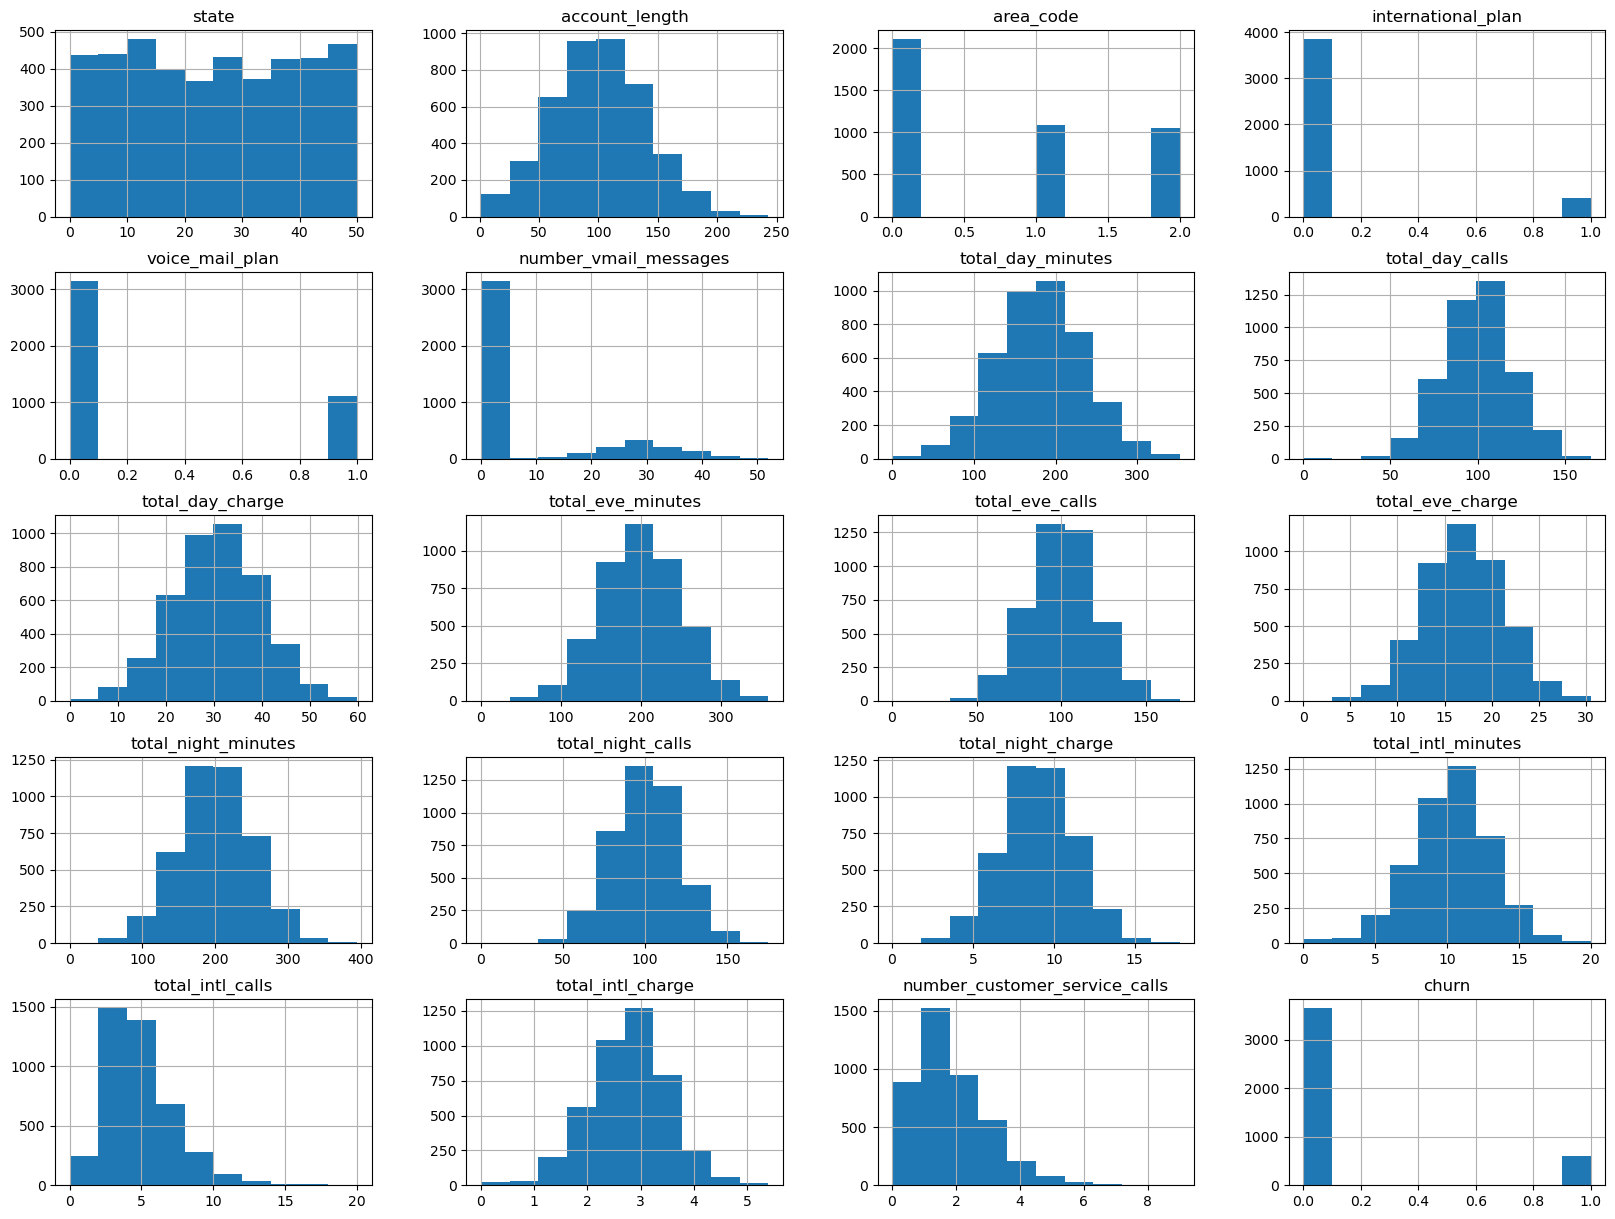

In [23]:
df.hist(figsize=(20, 15));

We can see that there are indeed dependence structure in our features. 

For example, ```number_vmail_messages``` depends on if ```voice_mail_plan=1```.

In [25]:
target = 'churn'

X = df.drop(columns=target)
y = df[target]

cont_col_names = list(set(X.columns) - set([*cate_cols, *bin_cols]))
cont_cols = [i for i, col in enumerate(X.columns) if col in cont_col_names]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=12345)

### 3.1 Naive Bayes Classifier

In [27]:
def split_cate_cont(X, cont_cols):
    X_cate = np.delete(X, cont_cols, axis=1)
    X_cont = X[:, cont_cols]
    return X_cate, X_cont

X_train_cate, X_train_cont = split_cate_cont(X_train, cont_cols)
X_test_cate, X_test_cont = split_cate_cont(X_test, cont_cols)

#### 3.1.1 Categorical

In [29]:
clf_cate = CategoricalNB()
clf_cate.fit(X_train_cate, y_train)
y_pred_prob_cate = clf_cate.predict_proba(X_test_cate)
y_pred_cate = np.argmax(y_pred_prob_cate, axis=1)

conf_mat_cate, test_stat_cate = confusion_matrix_metrics(y_test, y_pred_cate)
display(conf_mat_cate, test_stat_cate)

truth,0,1
pred,,
0,705,133
1,5,7


,precision,recall,fscore,support
0,0.841289,0.992958,0.910853,710
1,0.583333,0.050000,0.092105,140


#### 3.1.2 Gaussian

In [31]:
clf_nb = GaussianNB()
clf_nb.fit(X_train_cont, y_train)
y_pred_prob_cont = clf_nb.predict_proba(X_test_cont)
y_pred_cont = np.argmax(y_pred_prob_cont, axis=1)

conf_mat_cont, test_stat_cont = confusion_matrix_metrics(y_test, y_pred_cont)
display(conf_mat_cont, test_stat_cont)

truth,0,1
pred,,
0,688,76
1,22,64


,precision,recall,fscore,support
0,0.900524,0.969014,0.933514,710
1,0.744186,0.457143,0.566372,140


#### 3.1.3 Composite

In [33]:
y_pred_prob_comp = (y_pred_prob_cate * y_pred_prob_cont)
y_pred_prob_comp = y_pred_prob_comp / clf_nb.class_prior_
y_pred_prob_comp = y_pred_prob_comp / y_pred_prob_comp.sum(axis=1)[:, None]

y_pred_comp = np.argmax(y_pred_prob_comp, axis=1)
conf_mat_comp, test_stat_comp = confusion_matrix_metrics(y_test, y_pred_comp)
display(conf_mat_comp, test_stat_comp)

truth,0,1
pred,,
0,688,67
1,22,73


,precision,recall,fscore,support
0,0.911258,0.969014,0.939249,710
1,0.768421,0.521429,0.621277,140


### 3.2 CIBer

CIBer provided both organized treatments on all categorical, continuous and discrete feature variables

and efficient modelling of the dependence structure among them.

#### 3.2.1 Motivation

Treating all features as individually comonotonic could be too naive, 

hence a more appropriate way for classification problem is to partition the features into several subgroups and 

treat the features within groups as comonotonic while the totality of features in a group is independent of those in another group.

#### 3.2.3 Comonotonicity

It describes a special dependence among several random variables in that whenever the realization of one variable changes, 

the realizations of all other variables would change in the same direction. 

This synchronized movement manifests the extremal positive dependence, 

which often corresponds to the extremal behaviour of a stochastic system involving variables with fixed marginal distributions but in face of unknown dependence.

\
<u> Definition </u>

A set $S\subset\mathbb{R}^d$ is comonotonic if:

\begin{equation*}
    \text{For any } \mathbf{x}, \mathbf{y} \in S, \text{ either } \mathbf{x} \geq \mathbf{y} \text{ or } \mathbf{x} \leq \mathbf{y}. 
\end{equation*}

A random vector $\mathbf{X}$ in $\mathbb{R}^d$ is comonotonic if $\mathbb{P}(\mathbf{X}\in S)=1$ for some comonotonic set $S\subset\mathbb{R}^d$.

\
<u> Proposition </u>

Suppose that $\mathbf{X} = (X_1,\dots,X_d)$ is a random vector whose marginal cumulative distribution functions are $F_{X_1},\dots,F_{X_d}$, respectively. 

Then: 

\begin{equation*}
    F_{\mathbf{X}}(\mathbf{x})=\min_i F_{X_i}(x_i) \text{ for all } \mathbf{x}=(x_1,\dots,x_d)
\end{equation*}

In [40]:
CIBer_kwargs = {'cont_col': cont_cols,
                'asso_method': 'modified',
                'min_asso': 0.9,
                'disc_method': 'norm',
                'alpha': 1,
                'jointEncode': True,
                'n_bins': 10
}
mod = CIBer(**CIBer_kwargs)
mod.fit(X_train, y_train)

In [41]:
y_pred = mod.predict(X_test)
conf_mat, test_stat = confusion_matrix_metrics(y_test, y_pred)
display(conf_mat, test_stat)

truth,0,1
pred,,
0,697,100
1,13,40


,precision,recall,fscore,support
0,0.874529,0.981690,0.925017,710
1,0.754717,0.285714,0.414508,140
